<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Vision_and_Perception/blob/main/Emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
!rm -r Vision_and_Perception
!git clone https://github.com/FedericoRaschiatore0123/Vision_and_Perception
%cd Vision_and_Perception

rm: cannot remove 'Vision_and_Perception': No such file or directory
Cloning into 'Vision_and_Perception'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 44.03 MiB | 16.34 MiB/s, done.
/content/Vision_and_Perception


In [ ]:
!unzip Train_1.zip -d train
!unzip Train_2.zip -d train
!unzip Train_3.zip -d train
!unzip test.zip -d test

Output streaming troncato alle ultime 5000 righe.
 extracting: test/test/happy/PrivateTest_22108748.jpg  
 extracting: test/test/happy/PrivateTest_22154496.jpg  
 extracting: test/test/happy/PrivateTest_2260082.jpg  
 extracting: test/test/happy/PrivateTest_22689070.jpg  
 extracting: test/test/happy/PrivateTest_22929697.jpg  
 extracting: test/test/happy/PrivateTest_22938435.jpg  
 extracting: test/test/happy/PrivateTest_22979298.jpg  
 extracting: test/test/happy/PrivateTest_2309763.jpg  
 extracting: test/test/happy/PrivateTest_23250597.jpg  
 extracting: test/test/happy/PrivateTest_23282756.jpg  
 extracting: test/test/happy/PrivateTest_23344981.jpg  
 extracting: test/test/happy/PrivateTest_23400117.jpg  
 extracting: test/test/happy/PrivateTest_2352334.jpg  
 extracting: test/test/happy/PrivateTest_23574753.jpg  
 extracting: test/test/happy/PrivateTest_23578691.jpg  
 extracting: test/test/happy/PrivateTest_23631554.jpg  
 extracting: test/test/happy/PrivateTest_23782289.jpg  
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms

BATCH_SIZE=256

In [ ]:
# Specifica il percorso del tuo dataset
train_path = "../Vision_and_Perception/train"
test_path = "../Vision_and_Perception/test"
# Data augmentation
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

# Carica il dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=train_tfms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_tfms)

# Crea il DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print(train_dataloader)

256


In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


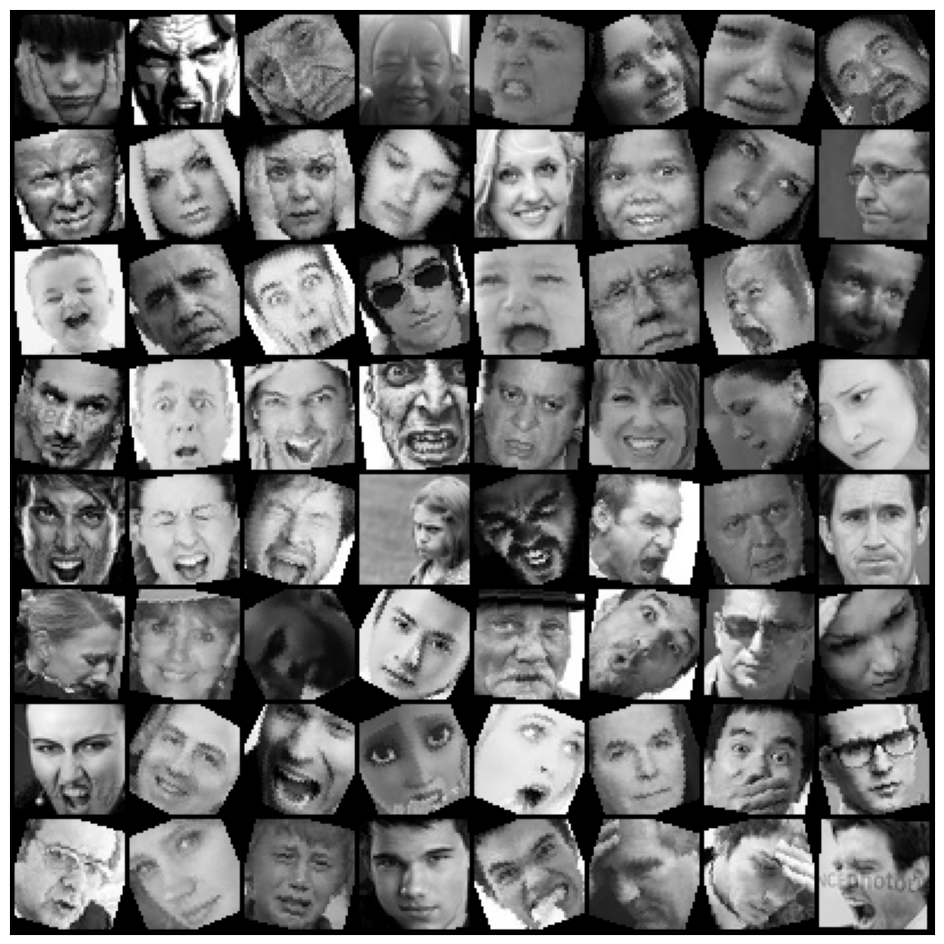

In [ ]:
show_batch(train_dataloader)

# CNN

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 48, kernel_size=5)
        self.conv2 = nn.Conv2d(48, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Transformer

In [ ]:
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F


class MultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)

    def forward(self, q, k, v, mask=False):
        q = self.split_heads(self.W_q(q))
        k = self.split_heads(self.W_k(k))
        v = self.split_heads(self.W_v(v))

        att = self.att_score(q, k, v, mask)
        out = self.W_o(self.combine_heads(att))

        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask:
            attn_scores = self.apply_mask(attn_scores)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(
            1, 2
        )

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self, tensor):
        mask = torch.triu(
            torch.full(
                (tensor.shape[2], tensor.shape[3]), float("-inf"), device=device
            ),
            diagonal=1,
        )
        tensor = tensor + mask

        return tensor


class EncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x, x, x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))

        return out


class Encoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                EncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(emb_dim, num_heads)

        self.cross_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim),
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3


class Decoder(pl.LightningModule):
    def __init__(
        self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
            [
                DecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x


class Transformer(pl.LightningModule):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=512,
        num_heads=8,
        num_layers=6,
        d_ff=256,
        dropout=0.1,
        teacher_forcing_ratio=0.9,
    ):
        super(Transformer, self).__init__()
        self.d_model = d_model

        self.num_heads = num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size = tgt_vocab_size

        self.transformer_encoder = Encoder(self.d_model, self.num_heads)
        self.transformer_decoder = Decoder(self.d_model, self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)

    def classic_forward(self, batch):
        src, tgt = batch
        max_seq_length = src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat(
            (torch.ones((batch_size, 1), dtype=torch.int).to(device), tgt[:, :-1]),
            dim=1,
        )

        src_embedded = self.dropout(self.src_embedding(src)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt)) + self.positional_encoding(
            max_seq_length, self.d_model
        ).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output

    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        losses.append(loss.cpu().detach().numpy())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(
            output.view(-1, output.size(-1)), tgt.view(-1)
        )
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len = batch_a.shape[1]

        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)
        acc.append(accuracy)
        return accuracy

    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length = x.shape[1]
        src_embedded = self.src_embedding(x).to(device) + self.positional_encoding(
            length, self.d_model
        ).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype=torch.int).to(device)
        out[:, 0] = 1
        output = torch.zeros(batch_dim, length, self.tgt_vocab_size).to(device)
        for i in range(length - 2):
            tgt_embedded = self.tgt_embedding(out) + self.positional_encoding(
                length, self.d_model
            ).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:, i] += self.fc(decode)[:, i]
            prob = F.softmax(output, dim=-1)
            arg_max = torch.argmax(prob, dim=-1)
            out[:, i + 1] = arg_max[:, i]
        return self.classic_forward((x, out))


torch.cuda.empty_cache()
acc = []
losses = []
voc_len = len(tokenizer.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t = Transformer(voc_len, voc_len)
t.to(device)
print(device)

trainer = pl.Trainer(max_epochs=1)
trainer.fit(t, train_loader)

model_path = "./model.pth"
torch.save(t.state_dict(), model_path)
